In [1]:
pip install netcdf4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import requests
import pandas as pd
from netCDF4 import Dataset, num2date
import numpy as np
import xarray as xr
import os
from shapely.geometry import Polygon, Point
import plotly.graph_objects as go
import matplotlib.pyplot as plt

Função para tratar DataFrame

In [4]:
def prepararDF(df, codigo):
  # Muda o tipo da coluna 'Data' para datetime (string --> datetime)
  df['Data'] = df['DataHora'][:10]
  df['Data'] = pd.to_datetime(df['Data'], format='%Y/%m/%d')

  # A coluna 'Data' e 'NivelConsistencia' são usadas como índice
  df.set_index(['Data','NivelConsistencia'], inplace=True)

  # Exclui colunas desnecessárias do dataframe
  listColumnsDrop = []
  for i in range(77):
    if i > 44:
      listColumnsDrop += [i]
  listColumnsDrop += [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  df = df.drop(df.columns[listColumnsDrop], axis=1)
  
  # Avalia se existe uma mesma data com diferentes níveis de consistência
  # Classificar o dataframe por data
  df.sort_values("Data", inplace=True)

  # Reseta os índices para passar "Data" como coluna e utilizar a mesma para apagar as linhas duplicadas
  df = df.reset_index()

  # apagas as linhas duplicadas, dando preferência ao dado consistido ('NivelConsistencia' = 2)
  df = df.drop_duplicates(subset='Data', keep='last', inplace=False)

  # A coluna 'Data' e 'NivelConsistencia' são usadas como índice
  df.set_index(['Data','NivelConsistencia'], inplace=True)

  # transforma as colunas de chuva em linhas com as respectivas datas
  # Este processo transforma todas as colunas em linhas, gerando um problema para os meses que possuem menos de 31 dias
  # Dessa forma, o dia 1 de um mês armazenava a chuva do dia 1 e a chuva do dia 31 (linha duplicada com valor NaN)
  # Correção explicada durante o processo:

  # usa a função .melt() para transformar todas as colunas em linhas. São mantidas as colunas ['Data', 'NivelConsistencia']
  # São criadas duas novas colunas: 'Dia' que recebe o nome da coluna que virou linha e 'Chuva' que recebe o valor que era armazenado na coluna
  df = df.reset_index().melt(id_vars=['Data', 'NivelConsistencia'], var_name='Dia', value_name='Chuva')

  # Fiz uma cópia da minha data em formato de texto
  df['Data1']=df['Data'].astype(str)

  # Apaguei os últimos 2 caracteres, assim ficou somente o texto com %Y-%m- ('1989-11-')
  df['Data1'] = df['Data1'].str[:-2]

  # Fiz uma cópia da coluna 'Dia' (exe: 'Chuva03'), a 'função .str.extract('(\d+)', expand=False)' deixa apenas os números
  # (então a coluna 'Dia1' armazena a string '03') ('Chuva03' --> '03')  
  df['Dia1'] = df['Dia'].str.extract('(\d+)', expand=False)
  
  # praticamente a mesma coisa da linha anterior, mudando apenas que substitui a própria coluna e o formato é int ('Chuva03' --> 3)
  df['Dia'] = df['Dia'].str.extract('(\d+)', expand=False).astype(int)

  # Como foram criadas várias linhas, tem vários índices repetidos da data, esta função soma os dias correspondente
  # aos da chuva guardado na coluna 'Dia' na data do índice (aqui é gerado o erro dos 31 dias)
  df['Data'] = df.apply(lambda x: x['Data'] + pd.DateOffset(days=x['Dia']-1), axis=1)

  # Aqui é feita uma concatenação do tipo '1989-11-'+'03' formando uma data.
  # Mas aqui também forma datas como '1989-02-31'
  df['Data1'] = df['Data1'] + df['Dia1']

  # A maioria das datas das colunas 'Data' e 'Data1' serão iguais, mas datas como '1989-02-31'
  # vão gerar valor NaT pois é um erro (exatamente nas linhas duplicadas)
  df['Data1'] = pd.to_datetime(df['Data1'], format='%Y-%m-%d', errors='coerce')

  # Aqui é apagada todas as linhas em que o erro NaT aparece na coluna 'Data1' (removendo os valores duplicados)
  df.dropna(inplace=True, subset=['Data1'])

  # reorganiza as colunas
  df = df[['Data', 'NivelConsistencia', 'Chuva']]

  # Classificar o dataframe por data
  df.sort_values("Data", inplace=True)

  # A coluna 'Data' e 'NivelConsistencia' são usadas como índice novamente
  #df.set_index(['Data'], inplace=True)
  df['Codigo'] = codigo
  return df

API para acessar dados da estação de código 936045

In [5]:
# API para solicitar dados de estações sem telemetria
estacoes = ['936045']
frames = []
for estacao in estacoes:
  url = 'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroSerieHistorica'
  params = {
      'codEstacao': estacao,
      'dataInicio': '',
      'dataFim': '',
      'tipoDados': '2',
      'nivelConsistencia': '',
  }
  try:
    response = requests.get(url, params=params)
    xml = response.text
    df1 = pd.read_xml(xml,
                      xpath="//SerieHistorica",
                      namespaces={"xs": "http://www.w3.org/2001/XMLSchema"})
  except ValueError:
    pass
  else:
    response = requests.get(url, params=params)
    xml = response.text
    df1 = pd.read_xml(xml,
                      xpath="//SerieHistorica",
                      namespaces={"xs": "http://www.w3.org/2001/XMLSchema"})
    df1 = prepararDF(df1, estacao)
    df1 = df1.dropna(subset=['Chuva'])
    #df1.reset_index()
    frames += [df1]
    df_936045 = frames[0]
print(f'Foram carregadas {len(frames)} estações')

Foram carregadas 1 estações


Acessando o mês de dezembro do ano 2000 (Único período coletado dos dados da NASA)

In [6]:
df_936045_dez = df_936045.set_index("Data").loc['2000-12-01':'2000-12-31']
df_936045_dez

,NivelConsistencia,Chuva,Codigo
Data,,,
2000-12-01,1,0.0,936045
2000-12-02,1,0.0,936045
2000-12-03,1,0.0,936045
2000-12-04,1,0.0,936045
2000-12-05,1,0.0,936045
2000-12-06,1,0.0,936045
2000-12-07,1,0.0,936045
2000-12-08,1,0.0,936045
2000-12-09,1,0.0,936045


Missão GPM

In [ ]:
# Diretório dos arquivos .nc4
diretorio = '/content/drive/MyDrive/ICD/Colab/Alexandre/GPM/'

# Coordenadas desejadas (X, Y)
lat = -9.1667
lon = -36.2167
	
# Criação do dataframe
df = pd.DataFrame(columns=['Date', 'Value'])

# Percorre os arquivos .nc4 no diretório
for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.nc4'):
        # Caminho completo do arquivo
        caminho_arquivo = os.path.join(diretorio, arquivo)
        
        # Abre o arquivo NetCDF e carrega os dados
        ds = xr.open_dataset(caminho_arquivo)
        f1 = Dataset(caminho_arquivo)
        time = f1.variables["time"]
        ## Data for only one day
        dates = num2date(time[:], time.units)
        data = dates[0].strftime("%Y-%m-%d")
        # Obtém as datas dos dados
        #dates = num2date(ds.time[:], ds.time.units)
        
        # Converte a primeira data para o formato "YYYY-MM-DD"
        #data = dates[0].strftime('%Y-%m-%d')
        
        # Seleciona o valor de precipitação na coordenada (X, Y)
        valor = float(ds['HQprecipitation'].sel(lat=lat, lon=lon, method='nearest').values)
        
        # Adiciona a data e o valor ao dataframe
        df = df.append({'Date': data, 'Value': valor}, ignore_index=True)

df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
# Imprime o dataframe resultante
#print(df)
df_nc4 = df
df_GPM = df_nc4.set_index(['Date'])

In [12]:
df_GPM

,Value
Date,
2000-12-01,0.000000
2000-12-02,0.000000
2000-12-03,0.000000
2000-12-04,0.000000
2000-12-05,0.000000
2000-12-06,0.000000
2000-12-07,0.000000
2000-12-08,0.000000
2000-12-09,0.000000


In [8]:
# Calcula a diferença absoluta entre as colunas 'Chuva' e 'Value'
diff = np.abs(df_936045_dez['Chuva'] - df_GPM['Value'])

# Cria o terceiro DataFrame com a coluna 'diferenca'
df_diferenca = pd.DataFrame({'diferenca': diff})
df_diferenca.index = df_GPM.index

df_diferenca

,diferenca
Date,
2000-12-01,0.000000
2000-12-02,0.000000
2000-12-03,0.000000
2000-12-04,0.000000
2000-12-05,0.000000
2000-12-06,0.000000
2000-12-07,0.000000
2000-12-08,0.000000
2000-12-09,0.000000


Comparação entre dados de chuva por satélite e estação

In [9]:

# Unir os dois dataframes com base nas datas
merged_df = df_nc4.merge(df_936045_dez, left_on='Date', right_on='Data')

# Definir as datas como índice
merged_df.set_index('Date', inplace=True)

# Criar figura interativa
fig = go.Figure()

# Adicionar barras do DataFrame df_nc4
fig.add_trace(go.Bar(
    x=merged_df.index,
    y=merged_df['Value'],
    name='df_nc4'
))

# Adicionar barras do DataFrame df_936045_dez
fig.add_trace(go.Bar(
    x=merged_df.index,
    y=merged_df['Chuva'],
    name='df_936045_dez'
))

# Atualizar layout do gráfico
fig.update_layout(
    title='Valores de Chuva, Dez 2000',
    #xaxis_tickangle=-45,
    xaxis=dict(
        title='Data'
    ),
    yaxis=dict(
        title='Valor de Chuva'
    )
)

# Exibir gráfico interativo
fig.show()

Olhando o gráfico é possível observar que o satélite estimou uma oscilação de chuva na área estudada entre os dias 12 e 17. Enquanto a estação em solo coletou chuva apenas nos dias 14, 15 e 16. Vale lembrar que o pixel da imagem de satélite abrange uma área enorme, enquanto a estação em solo obtem um dado pontual. Assim, é perfeitamente compreensível que o satélite detectou precipitação numa área relativamente próxima da estação em solo (mas não nela) e isto afetou todo o quadrante do pixel. Este mesmo pensamento pode ser aplicado para explicar a diferênça (em mm) das estimativas.

Diferença entre valores de chuva

In [10]:
# Cria a figura e o gráfico de barras
fig = go.Figure(data=[go.Bar(x=df_diferenca.index, y=df_diferenca['diferenca'])])

# Configurações do gráfico
fig.update_layout(
    title='Diferença entre Chuva e Value',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Diferença')
)

# Exibe o gráfico interativo
fig.show()

Avaliando os gráficos e as estatísticas, é possível observar que o acumulado diário de chuva medido em solo é bem maior que o estimado por satélite. É esperado que a precisão seja baixa em função da resolução do pixel analisado. No mais, comparações dessa natureza podem servir para avaliar se no período e no local choveu ou não.

CVDOT do dado GPM

Calcular o centro (C):

In [25]:
centro = df_GPM['Value'].mean()
centro

0.4538709367475202

Calcular a variação (V):

In [26]:
variacao = df_GPM['Value'].std()
variacao

1.5021098870145286

Analisar a distribuição (D):

<Axes: ylabel='Frequency'>

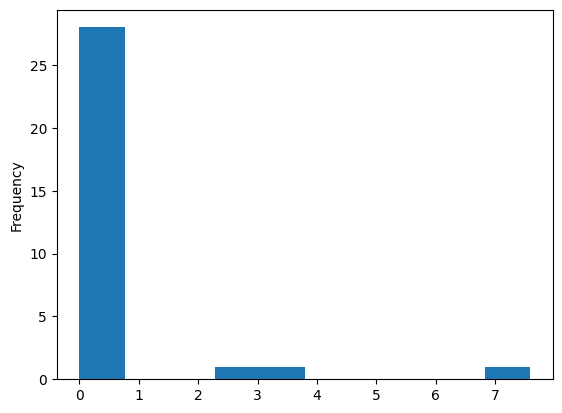

In [27]:
df_GPM['Value'].plot.hist()

Identificar outliers (O):

É considerado como outliers os valores que estão além de 3 desvios padrão da média.

In [28]:
limite_superior = centro + 3 * variacao
limite_inferior = centro - 3 * variacao

outliers = df_GPM[(df_GPM['Value'] > limite_superior) | (df_GPM['Value'] < limite_inferior)]
print(f'limite superior: {limite_superior}')
print(f'limite inferior: {limite_inferior}')
outliers

limite superior: 4.960200597791106
limite inferior: -4.052458724296066


,Value
Date,
2000-12-13,7.589999


tempo (T)

<Axes: xlabel='Date'>

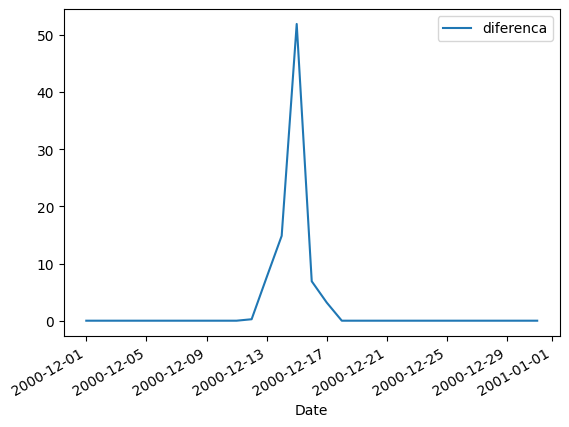

In [29]:
df_diferenca.plot(y='diferenca', kind='line')

CVDOT da diferença

Calcular o centro (C):

In [13]:
centro = df_diferenca['diferenca'].mean()
centro

2.7306451378330108

Calcular a variação (V):

In [15]:
variacao = df_diferenca['diferenca'].std()
variacao

9.658220834653815

Analisar a distribuição (D):

<Axes: ylabel='Frequency'>

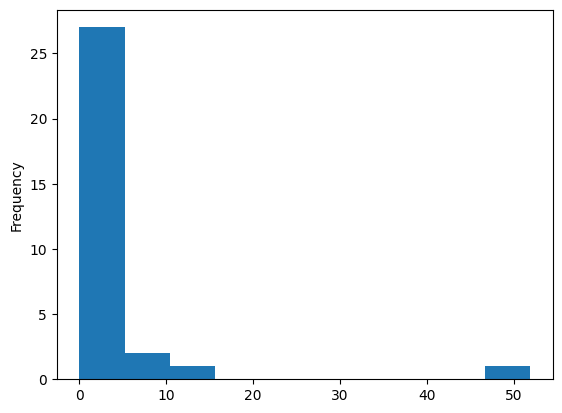

In [16]:
df_diferenca['diferenca'].plot.hist()

Identificar outliers (O):

É considerado como outliers os valores que estão além de 3 desvios padrão da média.

In [22]:
limite_superior = centro + 3 * variacao
limite_inferior = centro - 3 * variacao

outliers = df_diferenca[(df_diferenca['diferenca'] > limite_superior) | (df_diferenca['diferenca'] < limite_inferior)]
print(f'limite superior: {limite_superior}')
print(f'limite inferior: {limite_inferior}')
outliers

limite superior: 31.705307641794455
limite inferior: -26.244017366128432


,diferenca
Date,
2000-12-15,51.905


tempo (T)

<Axes: xlabel='Date'>

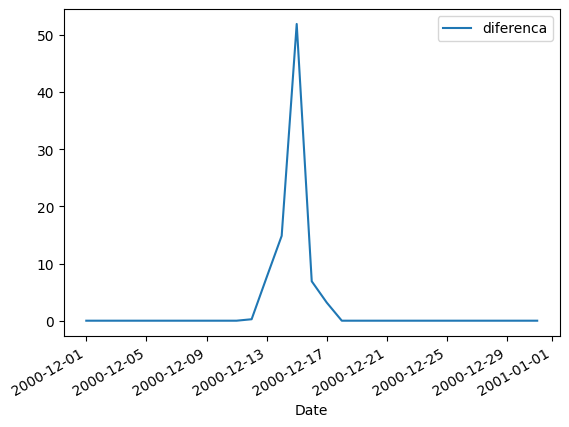

In [20]:
df_diferenca.plot(y='diferenca', kind='line')

OBS.: Apesar de ter encontrado 1 valor de outlier para cada série, não acredito que realmente pode ser sido um erro de leitura. Acredito que fatores climáticos explicam os dados. Além disso, esses valores correspondem ao pico da chuva no período central de tempo, levando a crer que foi o momento de chuva mais forte...